In [30]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [31]:
df = pd.read_csv('C:\\Users\\AAA\\Desktop\\dev\\LSTM과 BERT\\samsung.csv')
df=df.loc[::-1].reset_index(drop=True)
df

,일자,시가,고가,저가,종가,거래량
0,19850104,130,130,129,129,111764
1,19850105,129,129,128,128,108496
2,19850107,129,130,128,129,771895
3,19850108,129,129,127,127,845098
4,19850109,126,126,122,123,324836
...,...,...,...,...,...,...
9283,20191230,56200,56600,55700,55800,8356767
9284,20200102,55500,56000,55000,55200,12993228
9285,20200103,56000,56600,54900,55500,15422255
9286,20200106,54900,55600,54600,55500,10278951


In [32]:
data= df.iloc[:,4:5]
data

,종가
0,129
1,128
2,129
3,127
4,123
...,...
9283,55800
9284,55200
9285,55500
9286,55500


,종가
49,124.58
50,124.48
51,124.36
52,124.22
53,124.14
...,...
9283,52487.00
9284,52585.00
9285,52671.00
9286,52757.00


c:\users\aaa\anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\aaa\anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\aaa\anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\users\aaa\anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0, flags=flags)


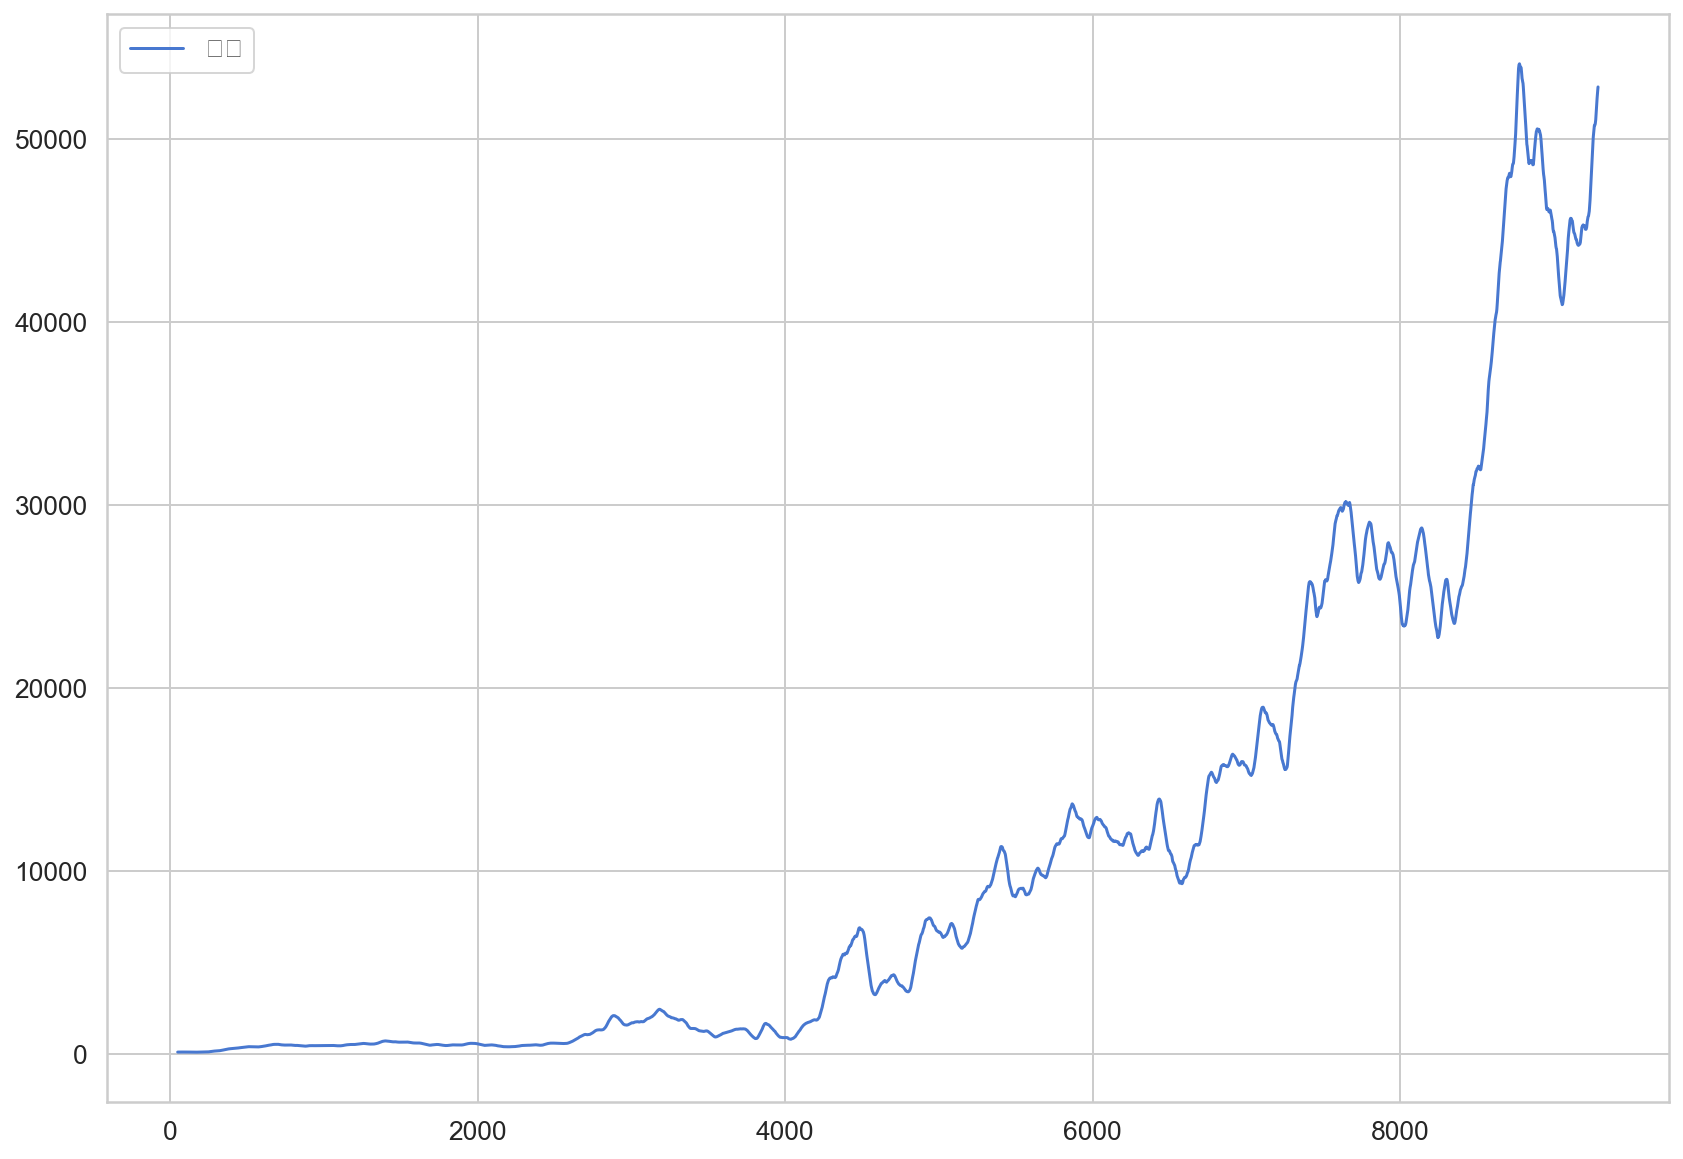

In [33]:
roll = data['종가'].rolling(window=50)
rolled= roll.mean()
rolled=pd.DataFrame(rolled)
rolled=rolled.dropna()
rolled.plot()
rolled


In [34]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [35]:
#지도학습용 데이터로 변환
seq_length = 5
X, y = create_sequences(rolled, seq_length)

for i in range(3):
    print(X[i], y[i])

[[124.58]
 [124.48]
 [124.36]
 [124.22]
 [124.14]] [124.12]
[[124.48]
 [124.36]
 [124.22]
 [124.14]
 [124.12]] [124.1]
[[124.36]
 [124.22]
 [124.14]
 [124.12]
 [124.1 ]] [124.1]


In [36]:
#학습용, 검증용, 시험용으로 분리
train_size = int(8700* 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:8700], y[train_size:8700]
X_test, y_test = X[8700:], y[8700:]

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

X_train =  sc.fit_transform(X_train.reshape(-1,1)).reshape(-1,seq_length)
y_train =sc.fit_transform(y_train.reshape(-1,1))
X_val = sc.fit_transform(X_val.reshape(-1,1)).reshape(-1,seq_length)
y_val =sc.fit_transform(y_val.reshape(-1,1))
X_test =sc.fit_transform(X_test.reshape(-1,1)).reshape(-1,seq_length)
y_test = sc.fit_transform(y_test.reshape(-1,1))

In [37]:
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print('학습을 진행하는 기기:',device)

True
학습을 진행하는 기기: cuda:0


In [38]:
# numpy -> tensor 변환
X_train = torch.tensor(X_train).float().to(device)
y_train = torch.tensor(y_train).float().to(device)
X_val = torch.tensor(X_val).float().to(device)
y_val = torch.tensor(y_val).float().to(device)
X_test = torch.tensor(X_test).float().to(device)
y_test = torch.tensor(y_test ).float().to(device)

In [39]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

torch.Size([6960, 5]) torch.Size([1740, 5]) torch.Size([534, 5])
torch.Size([6960, 1]) torch.Size([1740, 1]) torch.Size([534, 1])


In [40]:
class Predictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(Predictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [41]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0
        for idx, seq in enumerate(train_data): 
            model.module.reset_hidden_state() # seq 별 hidden state reset
            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))
        
        if val_data is not None:
            with torch.no_grad():
                val_loss = 0
                for val_idx, val_seq in enumerate(val_data):

                    model.module.reset_hidden_state() # seq 별로 hidden state 초기화 
                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):          
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :
                    print('\n Early Stopping')
                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [42]:
model = Predictor(
    n_features=1,
    n_hidden=3,
    seq_len=seq_length,
    n_layers=1
)
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): Predictor(
    (lstm): LSTM(1, 3)
    (linear): Linear(in_features=3, out_features=1, bias=True)
  )
)

In [43]:
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=200,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.004875379671761164 val loss: 0.45557746291160583
Epoch 10 train loss: 0.0008141949081835725 val loss: 0.02639261819422245
Epoch 20 train loss: 0.0007672616409700854 val loss: 0.029138294979929924
Epoch 30 train loss: 0.0007797306714941253 val loss: 0.027539897710084915
Epoch 40 train loss: 0.0007372486066596212 val loss: 0.02761983498930931
Epoch 50 train loss: 0.0007452794958477045 val loss: 0.03046082891523838
Epoch 60 train loss: 0.0007257896289230439 val loss: 0.03608601540327072
Epoch 70 train loss: 0.0007183965891167697 val loss: 0.0379677414894104
Epoch 80 train loss: 0.0006778956284401881 val loss: 0.03834519162774086
Epoch 90 train loss: 0.0007080790271039018 val loss: 0.03622036799788475
Epoch 100 train loss: 0.0006695978837854653 val loss: 0.039130572229623795

 Early Stopping


tensor(0.4556)


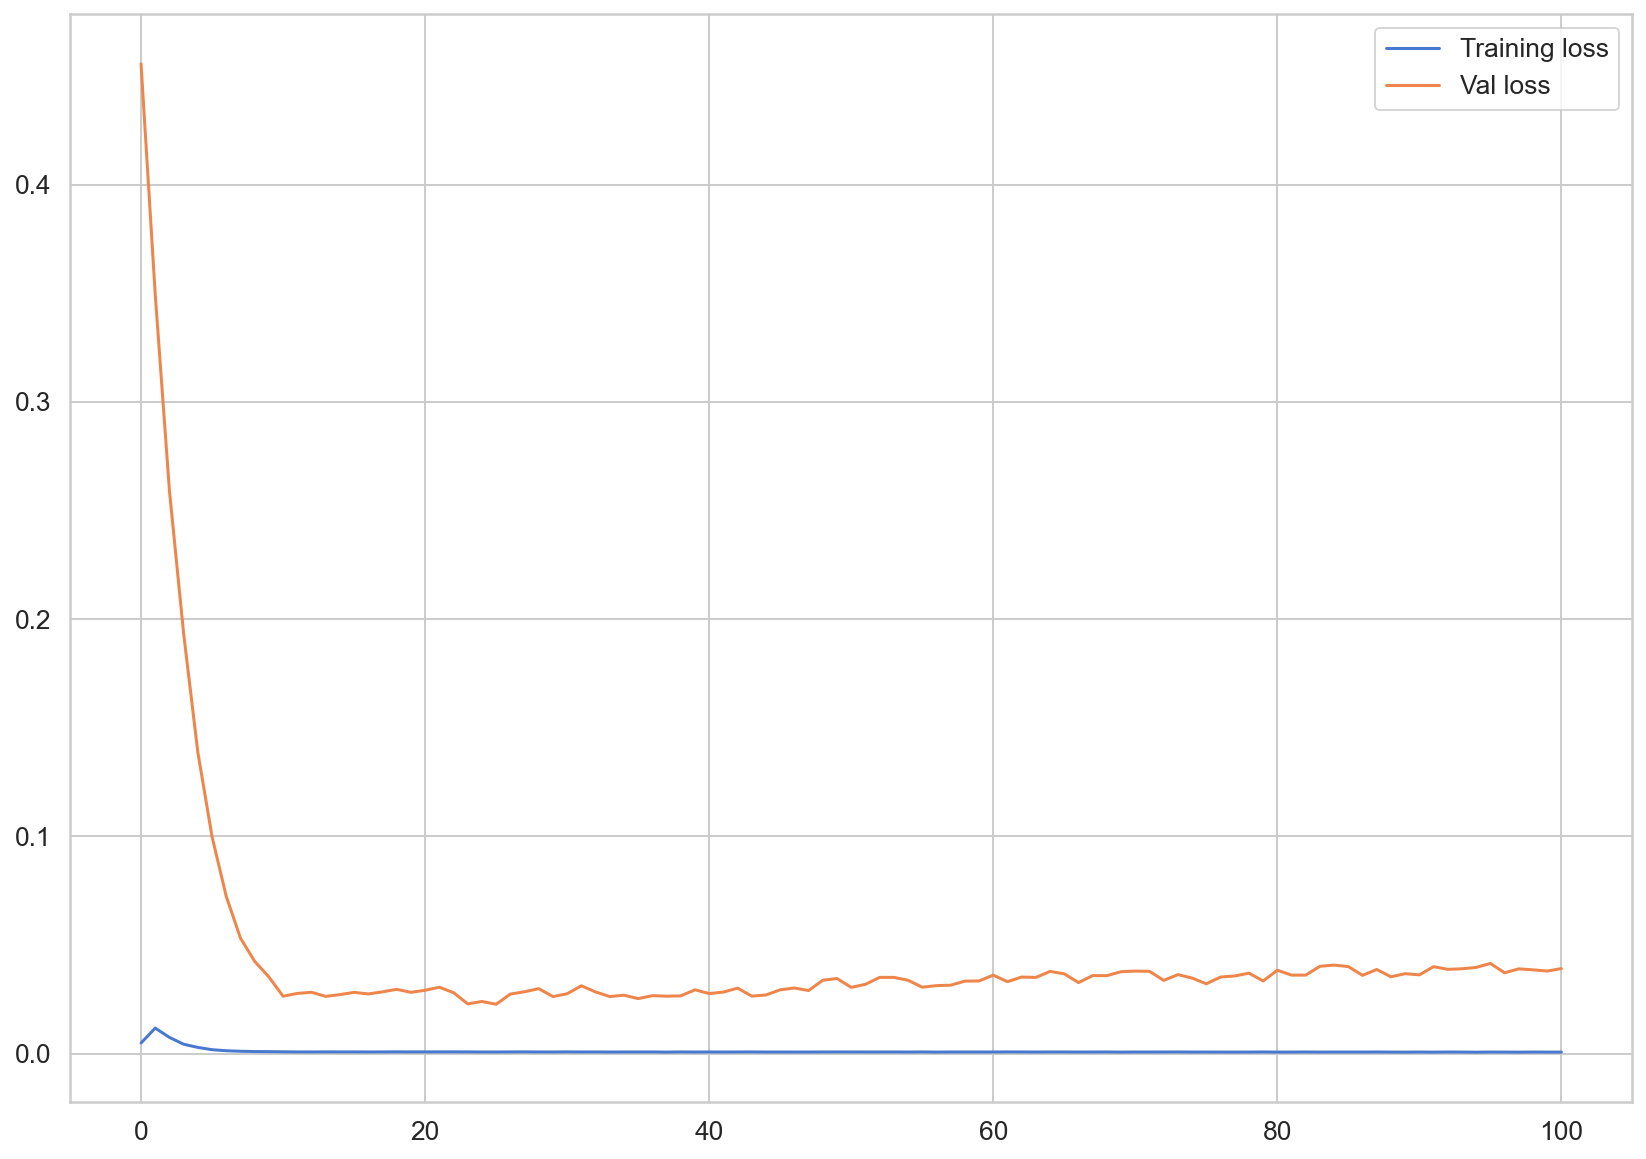

In [44]:
for _ in range(len(val_hist)):
    val_hist[_]=val_hist[_].cpu()
print(val_hist[0])
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

In [45]:
#one step 예측
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.module.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

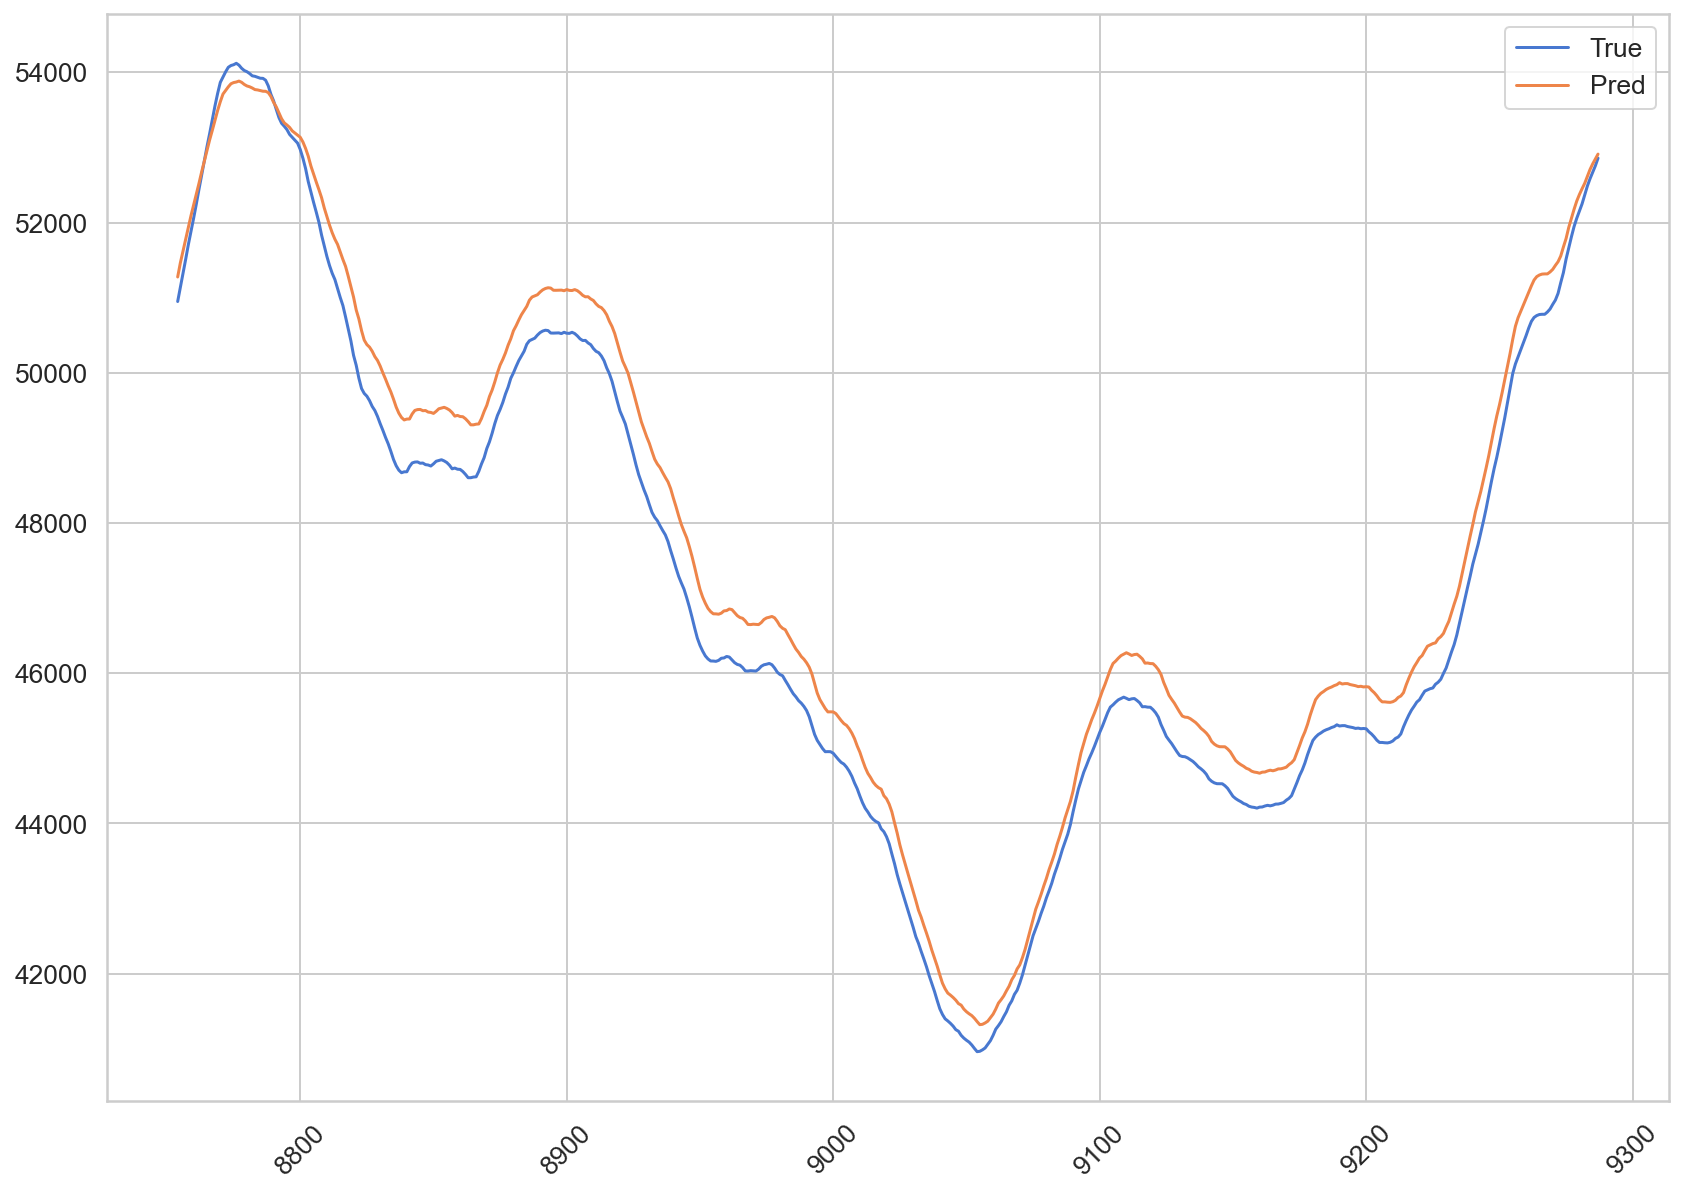

In [46]:
preds= sc.inverse_transform(np.array(preds).reshape(-1,1))

plt.plot(data.index[-len(y_test):], y[8700:], label='True')
plt.plot(data.index[-len(preds):], preds, label='Pred')
plt.xticks(rotation=45)
plt.legend()

In [47]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

MAE(y[8700:],preds)

509.18329149516825

In [48]:
#multi-step 예측

with torch.no_grad():
    test_seq = X_test[:1] # 첫번째 테스트 셋, 3차원
    preds = []
    for _ in range(len(X_test)):
        model.module.reset_hidden_state()
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.cpu().numpy().flatten()
        new_seq = np.append(new_seq, [pred]) # 시퀀스에 추가 
        new_seq = new_seq[1:] # 추가된 값을 포함하여 seq_length가 5개가 되도록 맞추기 
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

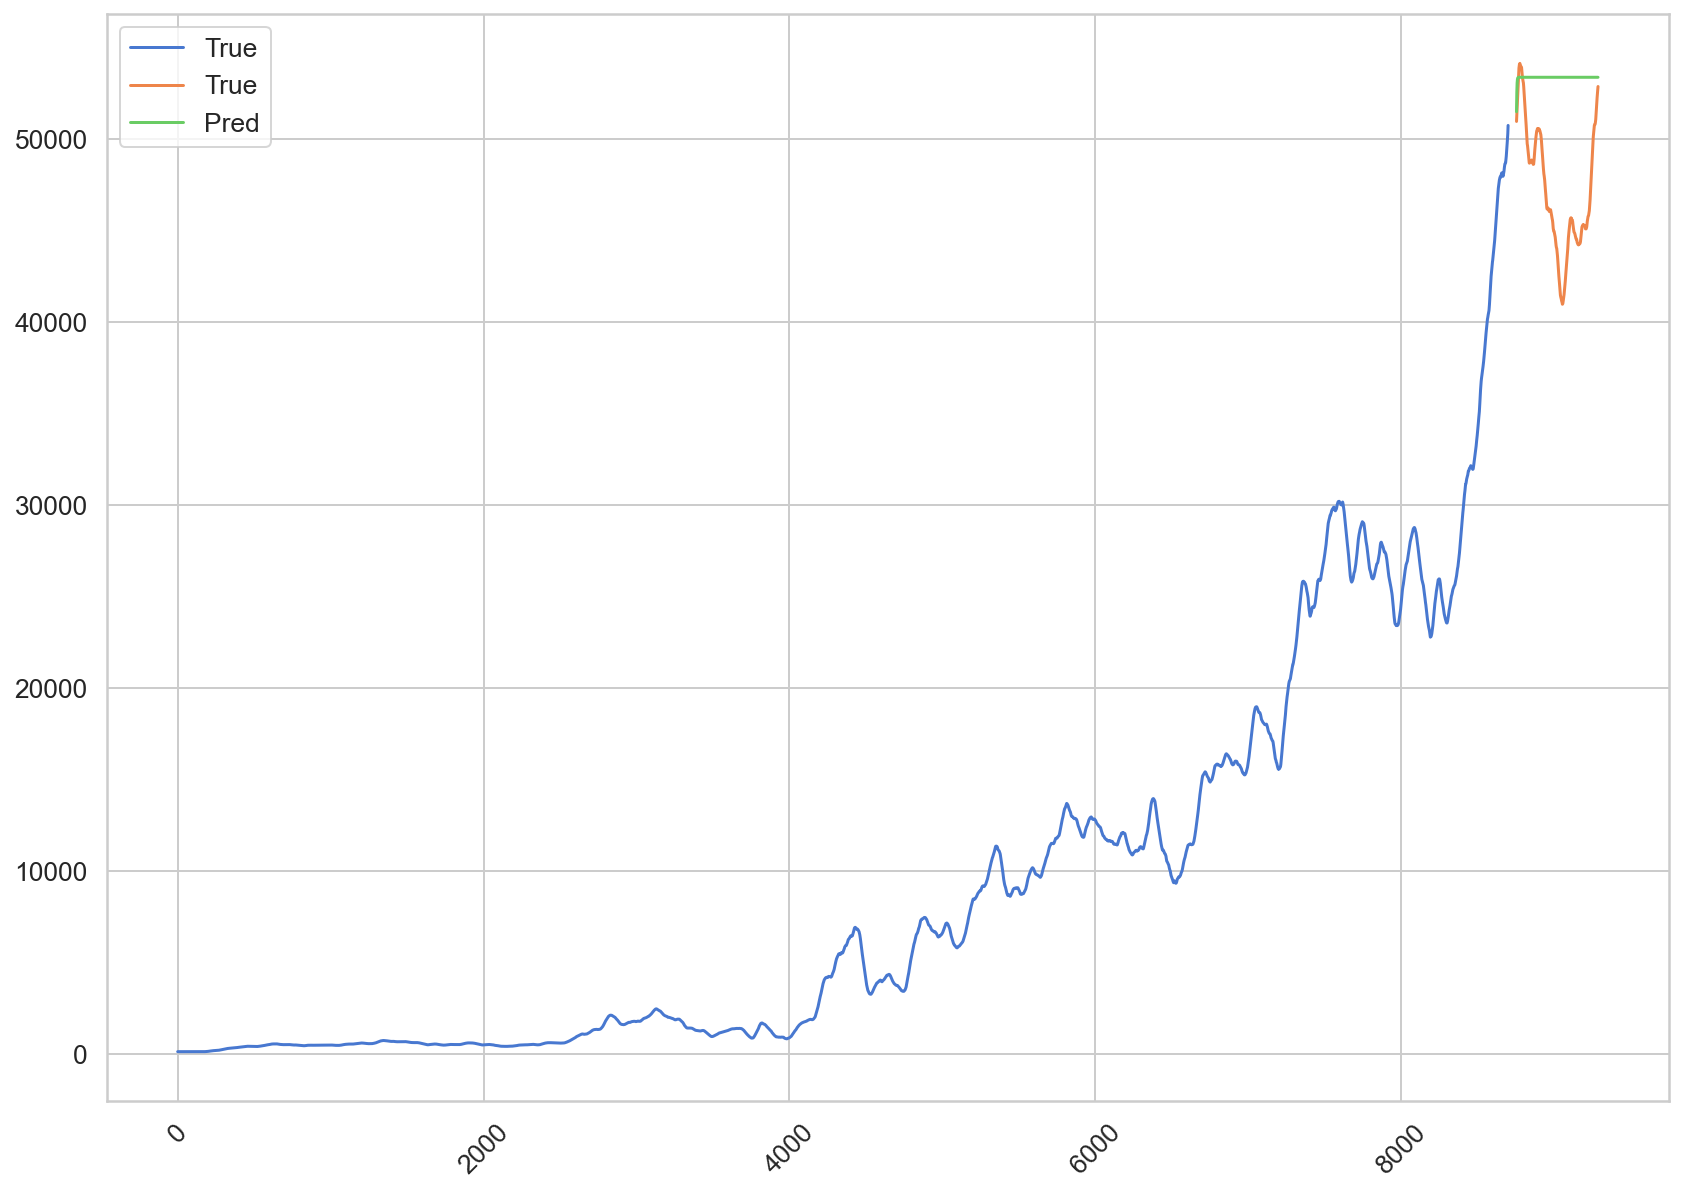

In [28]:
preds= sc.inverse_transform(np.array(preds).reshape(-1,1))

plt.plot(data.index[:8700], y[:8700], label='True')
plt.plot(data.index[-len(y_test):], y[8700:], label='True')
plt.plot(data.index[-len(preds):], preds, label='Pred')
plt.xticks(rotation=45)
plt.legend()

In [29]:
torch.save(model, 'model6.pt')